Times (ms): [0.       0.001833 0.002167 ... 0.698    0.6997   0.7007  ] 0.7007
Unit IDs: [384 680 465 ...  67  10 260]
Label: 11


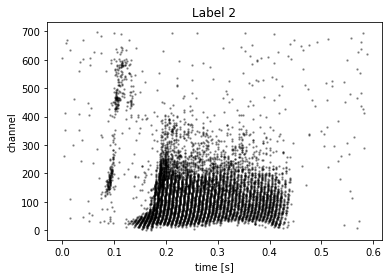

Number of samples:  2264
Number of samples:  8156


In [6]:
import os
import urllib.request
import gzip, shutil
# from keras.utils import get_file
import matplotlib.pyplot as plt
"""
The dataset is 48kHZ with 24bits precision
* 700 channels
* longest 1.17s
* shortest 0.316s
"""

# cache_dir=os.path.expanduser("~/data")
# cache_subdir="hdspikes"
# print("Using cache dir: %s"%cache_dir)
#
# # The remote directory with the data files
# base_url = "https://compneuro.net/datasets"

# Retrieve MD5 hashes from remote



# file_hashes = { line.split()[1]:line.split()[0] for line in lines if len(line.split())==2 }

files = ['D:\Ph.D\Research\SNN-SRT数据\SHD\extract\shd_test.h5','D:\Ph.D\Research\SNN-SRT数据\SHD\extract\shd_train.h5']

import tables
import numpy as np
fileh = tables.open_file(files[1], mode='r')
units = fileh.root.spikes.units
times = fileh.root.spikes.times
labels = fileh.root.labels

# This is how we access spikes and labels
index = 0
print("Times (ms):", times[index],max(times[index]))
print("Unit IDs:", units[index])
print("Label:", labels[index])


def binary_image_readout(times, units, dt = 1e-3):
    img = []
    N = int(1/dt)
    for i in range(N):
        idxs = np.argwhere(times <= i*dt).flatten()
        vals = units[idxs]
        vals = vals[vals > 0]
        vector = np.zeros(700)
        vector[700-vals] = 1
        times = np.delete(times, idxs)
        units = np.delete(units, idxs)
        img.append(vector)
    return np.array(img)

def binary_image_spatical(times, units, dt = 1e-3, dc = 10):
    img = []
    N = int(1/dt)
    C = int(700/dc)
    for i in range(N):
        idxs = np.argwhere(times<=i*dt).flatten()
        vals = units[idxs]
        vals = vals[vals > 0]
        vector = np.zeros(C)# add spacial count
        vector[700-vals] = 1
        times = np.delete(times,idxs)
        units = np.delete(units,idxs)
        img.append(vector)
    return np.array(img)


def generate_dataset(file_name, dt=1e-3):
    fileh = tables.open_file(file_name, mode='r')
    units = fileh.root.spikes.units
    times = fileh.root.spikes.times
    labels = fileh.root.labels

    # This is how we access spikes and labels
    index = 0
    print("Number of samples: ",len(times))
    X = []
    y = []
    for i in range(len(times)):
        tmp = binary_image_readout(times[i], units[i],dt=dt)
        X.append(tmp)
        y.append(labels[i])
    return np.array(X),np.array(y)

k = 125
plt.scatter(times[k],700-units[k], color="k", alpha=0.33, s=2)
plt.title("Label %i"%labels[k])
plt.xlabel('time [s]')
plt.ylabel('channel')
# plt.axis("off")
plt.show()

test_X,testy = generate_dataset(files[0],dt=10e-3)
np.save('./data/testX_10ms.npy',test_X)
np.save('./data/testY_10ms.npy',testy)

train_X,trainy = generate_dataset(files[1],dt=10e-3)
np.save('./data/trainX_10ms.npy',train_X)
np.save('./data/trainY_10ms.npy',trainy)

In [3]:
from spikingjelly.datasets.shd import SpikingHeidelbergDigits
SHD_train = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=True, data_type='frame', frames_number=250, split_by='number')
# SHD_train_aug = []
# for x, y in SHD_train:
#     SHD_train_aug.append([x, y])
#     for _ in range(2):
#         noise = np.array(np.random.random(x.shape)>0.95, dtype=np.float)
#         SHD_train_aug.append([x + noise, y])

SHD_test = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=False, data_type='frame', frames_number=250, split_by='number')

# train_loader = torch.utils.data.DataLoader(dataset=SHD_train_aug, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
# test_loader = torch.utils.data.DataLoader(dataset=SHD_test, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)

The directory [D:\Ph.D\Research\SNN-SRT数据\SHD\extract] for saving extracted files already exists.
SpikingJelly will not check the data integrity of extracted files.
If extracted files are not integrated, please delete [D:\Ph.D\Research\SNN-SRT数据\SHD\extract] manually, then SpikingJelly will re-extract files from [D:\Ph.D\Research\SNN-SRT数据\SHD\download].
Mkdir [D:\Ph.D\Research\SNN-SRT数据\SHD\frames_number_250_split_by_number].
Mkdir [D:\Ph.D\Research\SNN-SRT数据\SHD\frames_number_250_split_by_number\train].
Mkdir [D:\Ph.D\Research\SNN-SRT数据\SHD\frames_number_250_split_by_number\train\0].
Mkdir [D:\Ph.D\Research\SNN-SRT数据\SHD\frames_number_250_split_by_number\train\1].
Mkdir [D:\Ph.D\Research\SNN-SRT数据\SHD\frames_number_250_split_by_number\train\2].
Mkdir [D:\Ph.D\Research\SNN-SRT数据\SHD\frames_number_250_split_by_number\train\3].
Mkdir [D:\Ph.D\Research\SNN-SRT数据\SHD\frames_number_250_split_by_number\train\4].
Mkdir [D:\Ph.D\Research\SNN-SRT数据\SHD\frames_number_250_split_by_number\train\5

In [15]:
import torch
import torch.nn as nn
num_classes = 3
smoothing = 0.1
confidence = 1.0 - smoothing
pred = torch.rand(12, num_classes)

with torch.no_grad():
    true_dist = torch.zeros_like(pred)
    true_dist.fill_(smoothing / (num_classes - 1))

    target = torch.randint(low=0, high=2, size=(12, ))
    true_dist.scatter_(1, target.unsqueeze(1), confidence)

tensor([[0.0500, 0.9000, 0.0500],
        [0.9000, 0.0500, 0.0500],
        [0.0500, 0.9000, 0.0500],
        [0.0500, 0.9000, 0.0500],
        [0.0500, 0.9000, 0.0500],
        [0.0500, 0.9000, 0.0500],
        [0.9000, 0.0500, 0.0500],
        [0.0500, 0.9000, 0.0500],
        [0.0500, 0.9000, 0.0500],
        [0.0500, 0.9000, 0.0500],
        [0.9000, 0.0500, 0.0500],
        [0.0500, 0.9000, 0.0500]])

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from utils import A_cluster
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from copy import deepcopy

d:\Anaconda3\envs\snn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# NCP learning

In [55]:
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP, Random
from ncps.torch import LTC, CfC
import pytorch_lightning as pl
import torch
import torch.utils.data as data

data_x.shape:  (1, 48, 2)
data_y.shape:  (1, 48, 1)


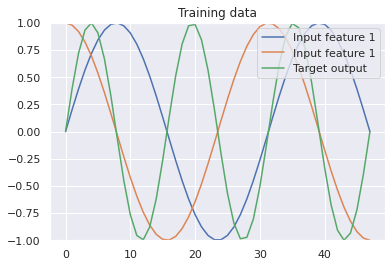

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
N = 48 # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack([np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1)
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
print("data_x.shape: ", str(data_x.shape))
print("data_y.shape: ", str(data_y.shape))
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
dataloader = data.DataLoader(data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4)

# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 1")
plt.plot(data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [3]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [56]:
in_features = 2
out_features = 1
wiring = AutoNCP(units=10, 
                 output_size=out_features,
                 sparsity_level=0.1,
                 )  # 16 units, 1 motor neuron
wiring = Random(units=10,
                output_dim=out_features,
                sparsity_level=0.1)
ltc_model = CfC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(logger=pl.loggers.CSVLogger("log"),
                     max_epochs=400,
                     gradient_clip_val=1,  # Clip gradient to stabilize training
                     accelerator='gpu',
                     devices=8,
                     )

AttributeError: 'WiredCfCCell' object has no attribute 'register_module'

In [57]:
from ncps.torch import CfC
from ncps.wirings import AutoNCP

wiring = AutoNCP(28, 4) # 28 neurons, 4 outputs
input_size = 20
rnn = CfC(input_size, wiring)

AttributeError: 'WiredCfCCell' object has no attribute 'register_module'

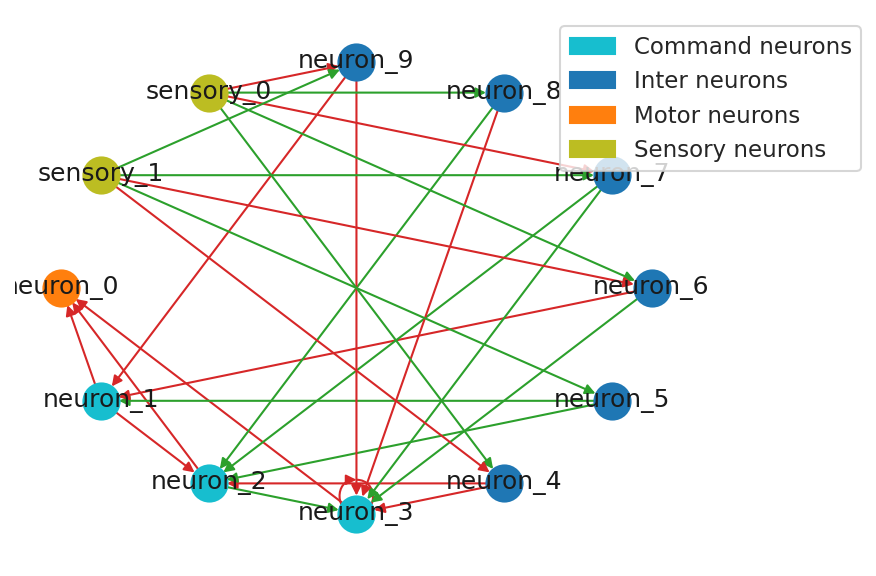

In [50]:
sns.set_style("white")
plt.figure(figsize=(6, 4), dpi=150)
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

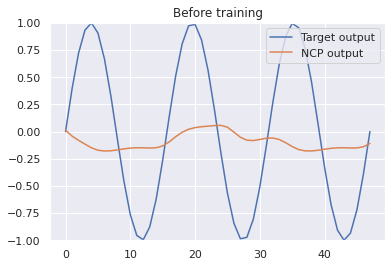

In [33]:
# Let's visualize how LTC initialy performs before the training
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [34]:
# Train the model for 400 epochs (= training steps)
hist = trainer.fit(model=learn,train_dataloaders=dataloader,)
    # x=data_x, y=data_y, batch_size=1, epochs=400,verbose=1)

/home/hhy/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/8
/home/hhy/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/8
/home/hhy/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/8
/home/hhy/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_ste

Training: 0it [00:00, ?it/s]

[W reducer.cpp:1303] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1303] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

In [37]:
hist

In [35]:
# Let's visualize the training loss
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist.history["loss"], label="Training loss")
plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.show()

AttributeError: 'NoneType' object has no attribute 'history'

<Figure size 432x288 with 0 Axes>

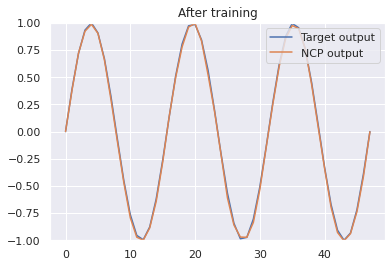

In [38]:
# How does the trained model now fit to the sinusoidal function?
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()

# 草稿本

In [1]:

import torch
import torch.nn.functional as F
import torch.nn as nn
import random
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import networkx as nx
import math
from data import Poisson_samples
from torch.distributions import Poisson
# import torch_geometric
# from torch_geometric.nn import GCNConv
# from torch_geometric.datasets import Planetoid
from RC import torchRC
from config import Config as config
# from torch_geometric.data import Data
# from sko.PSO import PSO
from utils import torchUniform, A_cluster, act
import dgl
from data import part_DATA
from config import Config
from train_gpu import inference

In [2]:
torch.set_default_dtype(torch.float32)
import numpy as np
import torch
import torch.nn as nn
from config import Config


from utils import set_seed
class Reservoir1(nn.Module):
    '''reservoir layer'''
    
    def __init__(self, config:Config):
        '''
        input: x, spike
        output: y
        '''
        super(Reservoir1, self).__init__()
        Win = config.Win
        b = config.bias
        N_in = config.N_in
        N_hid = config.N_hid
        device = config.device
        self.alpha = config.alpha
        
        self.W_in = torchUniform(-Win, Win, size=(N_hid, N_hid)).to(device).half()
        self.A = torch.tensor(A_cluster(config)).to(device).half()
        self.bias = torchUniform(-b, b, size=(N_hid)).to(device).half() # unif(-1,1)
        
    def forward(self, x, spike):
        '''
        x: (batch, N_in)
        W_in: (N_in, N_hid)
        spike: (batch, )
        '''
        U = torch.mm(x, self.W_in) # (batch, N_hid)
        r = torch.mm(spike, self.A)
        y = act(self.alpha * r + (1 - self.alpha) * (U + self.bias))
        return y
class torchRC1(nn.Module):
    '''
    Reservoir Computing Model in pytorch version
    for single layer version
    '''
    def __init__(self, config:Config) -> None:
        super(torchRC1, self).__init__()
        self.config = config
        self.N_in = config.N_in
        self.N_hid = config.N_hid
        self.mem_init = config.mem_init
        self.decay = config.LIF_decay
        # if self.decay is not a non-negative real number, initialize it to random vector
        if not self.decay:
            self.decay = torchUniform(low=0.2, high=1.0, size=(1, self.N_hid)).to(config.device).half()
            
        self.thr = config.LIF_thr
        self.R = config.R
        self.sub_thr = config.sub_thr
        self.frames = config.frames
        self.device = config.device
        
        # self.W_ins, self.As, self.Bias = self.reset(config)
        self.reservoir = Reservoir1(config).to(self.device).half()
        set_seed(config)
        
    def membrane(self, mem, x, spike):
        '''
        update membrane voltage for reservoir neurons
        mem   [batch, N_hid]
        x     [batch, N_hid]
        spike [batch, N_hid]
        '''
        mem = mem * self.decay - self.thr * (spike) + x # 
        # mem = mem * self.decay * (1-spike) + x
        spike = torch.tensor(mem>self.thr, dtype=torch.half)
        return mem, spike
    
    def forward(self, x):
        '''
        inference function of spiking version
        x: input tensor [batch, frames, N_in]
        
        return
        mems:        [batch, frames, N_hid]
        spike_train: [batch, frames, N_hid]
        '''
        batch = x.shape[0]
        layers = 1 # self.config.layers
        device = self.device
        
        spikes = torch.zeros(layers, batch, self.frames+1, self.N_hid).to(device).half() # including time=-1 initial spike vector
        mems = torch.zeros(layers, batch, self.frames+1, self.N_hid).to(device).half()
        mems[0,:,0,:] = torchUniform(-self.mem_init, self.mem_init, size=(batch, self.N_hid)).to(device).half() # layer 1 initial membrane potential
        
        for t in range(self.frames):
            y = self.reservoir(x[:,t,:], spikes[0,:,t,:])
            mem, spike = self.membrane(mems[0,:,t,:], y, spikes[0,:,t,:])
            mems[0,:,t+1,:] = mem
            spikes[0,:,t+1,:] = spike
            
        return mems[0], spikes[0]

In [3]:
class ConvNet(nn.Module):
    def __init__(self, input_size, config:Config):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dim = self.fc_dim(input_size)
        self.fc = nn.Linear(self.dim, config.N_hid)
    
    def fc_dim(self, input_size):
        x = self.layer1(torch.rand(input_size))
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        return x.shape[1] * x.shape[2] * x.shape[3]
    
    def forward(self, x):
        x = self.layer1(x)
        # print('cnn',x.dtype)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = self.fc(x.view(-1, self.dim))
        # out = out.reshape(out.size(0), -1)
        # out = self.fc(out)
        return x

In [4]:
def inference_new(RC:torchRC1, CNN:ConvNet, config:Config, data_loader,):
    '''
    用于Reservoir + GNN 进行图像分类的inference函数
    torchRC输出的mems和spikes [batch, frames, N_hid]
    不再对frames这一维度求平均，以合并维度，达到一个vector表征一个sample的目的
    而是用一个time series（长度frames）来表示一个神经元的动力过程，用所有神经元的time series联合表示reservoir的推理过程，即对一个样本的表征
    
    2022年12月1日06:10:28
    '''
    device = config.device
    frames = config.frames
    device = config.device
    labels = []
    spikes = None
    for i, (image, label) in enumerate(data_loader):
        batch = image.shape[0]
        
        # firing spikes
        x_enc = None
        for _ in range(frames):
            spike = (image > torch.rand(image.size())).float()
            repre_spike = CNN(spike.to(device).half())
            if x_enc is None: x_enc = repre_spike.view(batch, 1, config.N_hid)
            else: x_enc = torch.cat((x_enc, repre_spike.view(batch, 1, config.N_hid)), dim=1)
        mems, spike = RC(x_enc.to(device)) # [batch, frames, N_hid], [batch, frames, N_hid]
        # concat membrane and spike train
        concat = torch.cat((mems, spike), dim=-1) # [batch, frames, 2*N_hid]
        if spikes is None: spikes = concat # spikes = spike_sum
        else: spikes = torch.cat((spikes, concat), dim=0)
        labels.extend(label.numpy().tolist())
    print('finish inference')
    return spikes.detach(), torch.tensor(labels).to(device)

In [14]:
config = Config()
config.device = 'cuda:0'
config.data = 'cifar10'
config.train_num = 8000
config.test_num = 2000
config.N_hid = 200
config.frames = 15
cnn = ConvNet((2,3,32,32), config).to(config.device).half()
print('model parameter:', sum(p.numel() for p in cnn.parameters() if p.requires_grad))
rc = torchRC1(config).to(config.device).half()
train_loader, test_loader = part_DATA(config)

model parameter: 21096
Files already downloaded and verified
Files already downloaded and verified
Data Generation Finish


In [16]:
torch.cuda.empty_cache() 
train_rs, train_label = inference_new(rc, cnn, config, train_loader)
test_rs, test_label= inference_new(rc, cnn, config, test_loader)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 23.70 GiB total capacity; 19.71 GiB already allocated; 3.81 MiB free; 20.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

device(type='cuda', index=0)

In [9]:
torch.cuda.empty_cache() 

In [8]:
from train_gpu import train_mlp_readout
from RC import MLP
# config.epoch = 300

# reduce frame dimension
train_rs_mlp = train_rs[:,1:,:].mean(1)
test_rs_mlp = test_rs[:,1:,:].mean(1)
config.epoch = 1000
config.lr = 1e-4
mlp = MLP(2*config.N_hid, config.mlp_hid, config.N_out).to(config.device).half()
train_score, test_score, = train_mlp_readout(model=mlp, 
                                            config=config,
                                            X_train=train_rs_mlp,
                                            X_test=test_rs_mlp,
                                            y_train=train_label,
                                            y_test=test_label)

[1,1000] loss:nan, train acc:0.1036, test acc:0.1100
[2,1000] loss:nan, train acc:0.1040, test acc:0.1100
[3,1000] loss:nan, train acc:0.1040, test acc:0.1100
[4,1000] loss:nan, train acc:0.1040, test acc:0.1100
[5,1000] loss:nan, train acc:0.1040, test acc:0.1100
[6,1000] loss:nan, train acc:0.1040, test acc:0.1100
[7,1000] loss:nan, train acc:0.1040, test acc:0.1100
[8,1000] loss:nan, train acc:0.1040, test acc:0.1100
[9,1000] loss:nan, train acc:0.1040, test acc:0.1100
[10,1000] loss:nan, train acc:0.1040, test acc:0.1100
[11,1000] loss:nan, train acc:0.1040, test acc:0.1100
[12,1000] loss:nan, train acc:0.1040, test acc:0.1100
[13,1000] loss:nan, train acc:0.1040, test acc:0.1100
[14,1000] loss:nan, train acc:0.1040, test acc:0.1100
[15,1000] loss:nan, train acc:0.1040, test acc:0.1100
[16,1000] loss:nan, train acc:0.1040, test acc:0.1100
[17,1000] loss:nan, train acc:0.1040, test acc:0.1100
[18,1000] loss:nan, train acc:0.1040, test acc:0.1100
[19,1000] loss:nan, train acc:0.1040,

KeyboardInterrupt: 

In [ ]:
config = Config()
config.data = 'mnist'
config.train_num = 2000
config.test_num = 1000
config.N_in = 28*28
config.N_out = 10
train_loader, test_loader = part_DATA(config)

model = torchRC(config)
train_rs, train_label = inference(model, config, train_loader,)

Data Generation Finish
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39


In [26]:
train_rs.shape

torch.Size([40, 101, 400])

In [2]:
Egat = EGAT(config)
model = torchRC(config)
mem, spike = model(torch.rand(16, config.frames, 50)*100)
# plt.figure(0)
# plt.imshow(mem[0,2,1:,:])
# plt.figure(1)
# plt.imshow(spike[0,2,1:,:])

mems = mem[0, 0, 1:, :].view(200,100) # [N_hid, frames]
# spikes = spike[0, :, 1:, :].T # [N_hid, frames]

A = model.reservoir.A.numpy()
edge_index = torch.tensor(np.where(A!=0), dtype=torch.long)
edge_attr = torch.tensor(np.array([A[i,j] for i,j in edge_index.T]))
u = edge_index[0]
v = edge_index[1]
g = dgl.graph((u, v))
node_feats = Egat(g, mems, edge_attr.view(-1,1))

In [3]:
node_feats.shape

torch.Size([4])

In [64]:
for i in egat.named_parameters():
    print(i[1].shape)

torch.Size([1, 1, 1])
torch.Size([1])
torch.Size([8, 100])
torch.Size([1, 100])
torch.Size([1, 100])
torch.Size([1, 1])


In [63]:
num_nodes, node_dim, edge_dim = 200, 100, 1

egat = EGATConv(in_node_feats=node_dim,
                in_edge_feats=edge_dim,
                out_node_feats=8,
                out_edge_feats=1,
                num_heads=1)
node_feats, _ = egat(g, mems, edge_attr.view(-1,1))
node_feats, _ = egat(g, node_feats.mean(1), edge_attr.view(-1,1))
node_feats.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (200x8 and 100x1)

In [17]:

T = 1000
rate = 150
N_in = 2
samples = torch.zeros(T, N_in, dtype=torch.float32)

# average time interval for two next spikes
interval_mean = (T / rate) * torch.ones(N_in)
interval_generate = Poisson(interval_mean)
interval_sum = torch.zeros(N_in, dtype=torch.int32)
stamps = []
# spike = torch.zeros(T, N_in, dtype=torch.int32)
while True:
    # sample the next spiking interval
    interval = interval_generate.sample().int()
    interval_sum += interval
    stamps.append(interval_sum)
    if (interval_sum>T-1).sum()==N_in:
        break
    # if interval_sum > T-1:
    #     break
    # for i, interval in enumerate(interval_sum):
    #     if interval < T-1:
    #         spike[interval, i] = 1.

In [14]:
stamps = torch.tensor(stamps)
stamps.shape

TypeError: only integer tensors of a single element can be converted to an index

best_x is  [0.   0.05 0.5 ] best_y is [0.25]


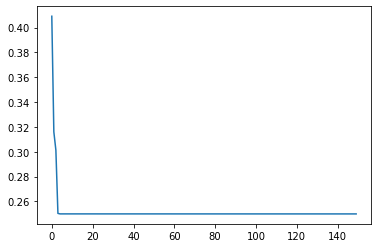

In [65]:
def demo_func(x):
    selected_nodes = []
    for i in range(10):
        selected_nodes.append(x[i*2] + 10*x[i*2+1])
    selected_nodes = sorted(selected_nodes)
    return 
pso = PSO(func=demo_func, n_dim=20, pop=40, max_iter=150, lb=[0, 0, 0], ub=[10, 10, 10], w=0.8, c1=0.5, c2=0.5)
pso.run()
print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)
plt.plot(pso.gbest_y_hist)
plt.show()

In [17]:
mems = mem[0,0,1:].T
mems.shape

torch.Size([200, 100])

In [59]:
edge_index = torch.tensor(np.where(model.reservoir.A!=0), dtype=torch.long)
edge_attr = torch.tensor(np.array([model.reservoir.A[i,j] for i,j in edge_index.T]))
# y = torch.rand(100, 1, dtype=torch.float) * 0.1 + torch.sin(torch.tensor([[i] for i in range(100)]))
data = Data(x=mems, edge_index=edge_index, y=None, edge_attr=edge_attr)

In [80]:
edges = torch.tensor([2, 5, 3]), torch.tensor([3, 5, 0]) 

In [81]:
edges

(tensor([2, 5, 3]), tensor([3, 5, 0]))

In [78]:
conv1 = GCNConv(100, 16, improved=True)
out = conv1(mems, edge_index, edge_attr) # edge_attr
out[0:10]

tensor([[     nan,      nan,      nan,      nan,      nan,      nan,      nan,
              nan,      nan,      nan,      nan,      nan,      nan,      nan,
              nan,      nan],
        [  4.7690,   2.6346,   2.9285,   1.6222,   0.2169,   0.1569,  -7.0377,
          -4.7773,  -2.0249,  -6.4779,  -3.7112,  -0.9646,  -2.3944,   2.4547,
          10.5767,  -4.3423],
        [  0.0392,   1.0259,   0.8961,  -0.0489,   0.7231,   0.3178,  -0.9069,
          -3.1562,  -0.3634,  -2.1491,  -1.5286,  -0.0930,  -1.4673,   1.8021,
           2.3846,  -2.2972],
        [  3.8538,   5.9477,   6.5850,  -0.9021,   0.3333,  -0.1355,  -7.3003,
         -16.9247,  -3.1416, -10.3588,  -6.3755,   5.9459,  -7.6476,   4.7750,
          14.6812, -10.8378],
        [ -0.5499,  -1.1580,  -2.2049,  -0.0702,   0.1906,   1.2750,  -1.0569,
          -0.1658,  -0.4330,  -0.2511,  -0.8606,  -1.2135,   1.2529,   1.6431,
           0.0512,  -0.5450],
        [  1.8140,   1.2847,   1.8552,   0.3750,  -0.6064,  

In [112]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 16, improved=True) # dataset.num_node_features
        self.conv2 = GCNConv(16, 1, improved=True) # dataset.num_classes

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr) # TODO 图卷积使用二值邻接矩阵还是实数邻接矩阵？
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return x # F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
# data = dataset[0].to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    # print(out.shape, data.y.shape)
    loss = F.mse_loss(out, data.y)
    print(epoch, loss.item())
    loss.backward()
    optimizer.step()

0 0.505687415599823
1 0.505687415599823
2 0.505687415599823
3 0.5418736934661865
4 0.505687415599823
5 0.505687415599823
6 0.505687415599823
7 0.505687415599823
8 0.505687415599823
9 0.505687415599823
10 0.505687415599823
11 0.505687415599823
12 0.505687415599823
13 0.505687415599823
14 0.505687415599823
15 0.505687415599823
16 0.505687415599823
17 0.505687415599823
18 0.505687415599823
19 0.505687415599823
20 0.505687415599823
21 0.505687415599823
22 0.505687415599823
23 0.505687415599823
24 0.505687415599823
25 0.505687415599823
26 0.505687415599823
27 0.505687415599823
28 0.505687415599823
29 0.505687415599823
30 0.505687415599823
31 0.505687415599823
32 0.505687415599823
33 0.505687415599823
34 0.505687415599823
35 0.505687415599823
36 0.505687415599823
37 0.505687415599823
38 0.505687415599823
39 0.505687415599823
40 0.505687415599823
41 0.505687415599823
42 0.505687415599823
43 0.505687415599823
44 0.505687415599823
45 0.505687415599823
46 0.505687415599823
47 0.505687415599823
4

In [19]:
import torch
from RC import torchRC
from config import Config as config
from data import PoissonDataset, part_DATA
from train_gpu import learn


In [21]:
model = torchRC(config)
with torch.no_grad():
    for i in range(config.N_hid):
        for j in range(config.N_hid):
            if torch.rand(1) < 0.2:
                model.As[0][i,j] = 0.

In [22]:

if config.data == 'poisson':
    train_loader, test_loader = PoissonDataset(config)
else:
    train_loader, test_loader = part_DATA(config)
loss = learn(model, train_loader, test_loader, config)

UnboundLocalError: local variable 'train_dataset' referenced before assignment

In [40]:
spike.shape

torch.Size([100, 50])

In [22]:
from RC import torchRC
from config import Config as config
config.device = 'cpu'
config.N_in = 50
config.frames = 100
config.batch_size = 32
model = torchRC(config)

In [139]:
# nx.in_degree_centrality(G)
# nx.out_degree_centrality(G)
nx.closeness_centrality(G)

{0: 0.4166666666666667,
 1: 0.7142857142857143,
 2: 0.5,
 3: 0.5555555555555556,
 4: 0.5,
 5: 0.7142857142857143}

In [21]:
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),  # 图片转张量，同时归一化0-255 ---》 0-1
])

train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                                train=True,
                                                download=False,
                                                transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                                train=False,
                                                download=False,
                                                transform=train_transform)
train_dataset, _ = torch.utils.data.random_split(train_dataset, [50000, 0])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=50, 
                                              shuffle=True, 
                                              num_workers=0,)

In [22]:
class ConvNet(nn.Module):
    def __init__(self, config:Config):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, config.N_hid)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
cnn = Conv

1000

In [16]:
count = [0]*10
for i, (img, label) in enumerate(train_loader):
    for j in label:
        count[j] += 1
print(count)

[116, 99, 103, 83, 109, 91, 106, 100, 101, 92]


In [57]:

random_list = torch.tensor(random.sample(list(range(len(train_dataset))), 5000))
train_data = train_dataset.data[random_list]
train_label = train_dataset.targets[random_list]

random_list = random.sample(list(range(len(test_dataset))), 1000)
test_data = test_dataset.data[random_list]
test_label = test_dataset.targets[random_list]

TypeError: only integer tensors of a single element can be converted to an index

In [1]:
from data import part_CIFAR10, part_MNIST
train_data, train_label, test_data, test_label = part_CIFAR10(5000,1000)

c:\ProgramData\Anaconda3\envs\snn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: only integer scalar arrays can be converted to a scalar index

In [12]:

# train_dataset = torchvision.datasets.MNIST(root='./data/', 
#                                             train=False, 
#                                             download=False, 
#                                             transform=transforms.ToTensor())
# random_list = random.sample(list(range(len(train_dataset))), 2000)
# data = train_dataset.train_data[random_list]
# label = train_dataset.targets[random_list]

Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Extracting ./data/cifar-10-python.tar.gz to ./data/


In [55]:
random_list = np.array(random.sample(list(range(len(data))), len(data)))
batch = 100
iter = int(len(data) / batch)
for i in range(iter):
    print(data[random_list[i*batch:(i+1)*batch]].shape)
    print(label[random_list[i*batch:(i+1)*batch]])

torch.Size([100, 28, 28])
tensor([4, 9, 4, 0, 0, 9, 3, 8, 6, 0, 1, 9, 7, 0, 4, 0, 4, 5, 1, 6, 1, 2, 1, 6,
        2, 1, 8, 3, 0, 3, 4, 6, 2, 1, 9, 0, 8, 8, 6, 9, 3, 0, 9, 7, 3, 5, 6, 5,
        5, 3, 7, 0, 4, 7, 1, 4, 8, 5, 8, 2, 2, 9, 7, 3, 1, 0, 9, 3, 1, 4, 6, 9,
        1, 2, 2, 7, 9, 8, 6, 1, 2, 6, 1, 0, 7, 4, 9, 5, 7, 0, 6, 8, 0, 5, 4, 4,
        0, 3, 3, 2])
torch.Size([100, 28, 28])
tensor([4, 9, 3, 9, 6, 3, 1, 6, 8, 3, 8, 4, 8, 0, 7, 8, 6, 7, 0, 7, 0, 3, 7, 8,
        0, 7, 4, 1, 3, 1, 8, 2, 8, 7, 1, 6, 4, 7, 0, 9, 9, 7, 8, 0, 1, 1, 9, 3,
        9, 5, 6, 8, 3, 4, 0, 5, 7, 5, 0, 6, 9, 6, 9, 0, 9, 9, 0, 8, 6, 0, 3, 4,
        1, 2, 8, 8, 7, 0, 8, 1, 8, 6, 4, 5, 0, 9, 4, 3, 4, 3, 2, 5, 6, 3, 0, 0,
        9, 2, 5, 5])
torch.Size([100, 28, 28])
tensor([5, 1, 4, 2, 6, 9, 8, 6, 0, 8, 7, 3, 1, 7, 4, 8, 9, 3, 7, 5, 5, 8, 8, 2,
        7, 9, 5, 7, 6, 2, 9, 4, 2, 1, 8, 1, 3, 4, 4, 3, 0, 5, 2, 3, 9, 6, 1, 6,
        5, 0, 1, 1, 5, 2, 8, 9, 0, 1, 9, 3, 9, 7, 4, 3, 2, 0, 6, 7, 2, 1, 5, 5,


tensor(7)


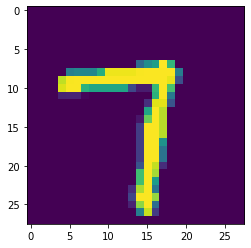

In [46]:
plt.imshow(data[280])
print(label[280])

In [47]:
count = [0]*10
for l in label:
    # print(count[l.item()])
    count[l.item()] += 1
print(count)


[200, 207, 195, 202, 227, 178, 185, 203, 191, 212]


In [3]:
from net import Developmental_Time_Window
from config import Config
A = Developmental_Time_Window(Config.N_hid,
                              Config.k,
                              Config.beta,
                              Config.R_,
                              Config.r,
                              Config.p_self,
                              Config.omega,)

KeyboardInterrupt: 

In [14]:
def a(**kwargs):
    print(kwargs, 'in A')
    def b(**kwargs):
        print(kwargs, 'in B')
    b(**kwargs)
a(a=1)

{'a': 1} in A
{'a': 1} in B


In [9]:
from utils import A_cluster

A = A_cluster(N_hid=100,
                  p_in=0.2,
                  gamma=1.0,
                  binary=False,
                  type='ERC',
                  noise=True,
                  noise_strength=0.2,
                  p_ER=0.2,
                  k=4)

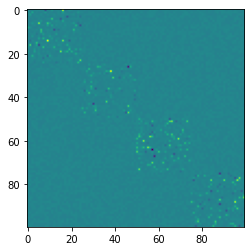

In [10]:
plt.imshow(A)

In [ ]:
# 这段代码废弃了

# STEP1: random coordinates of new nodes
N_coordinates = []
for _ in range(N):
    U_theta = np.random.uniform(0,1)
    l = np.random.uniform(0, R)
    coordinate = [l*np.cos(2*np.pi*U_theta), l*np.sin(2*np.pi*U_theta)]
    N_coordinates.append(coordinate)
N_coordinates = np.array(N_coordinates)

A = np.zeros((N, N), dtype=np.float32) # adjacency matrix
t = 0
for i in range(N):
    t += 1/N
    
    # diagonal = 0, self-connection forbidden
    A[i, i] = 0
    
    # STEP2: associated to nearest pioneer node with same time window w(U)
    xyi = N_coordinates[i, :]
    dis_pioneer = np.sqrt(np.sum((pioneer_nodes - xyi)**2, 1))
    nearest_i = np.argmin(dis_pioneer) + 1
    P_time_U = TimeWindowFunction(t, nearest_i, k, alpha)
    
    # STEP3: decide each edge with former nodes
    sum = 0
    #  if no edge to any existing nodes can be established, the new node is resampled.
    while sum == 0:
        for j in range(0, i):
            
            xyj = N_coordinates[j, :]
            P_dist = DistanceFunction(xyi, xyj) # P distance between U and V
            
            # associated to nearest pioneer node with same time window w(V)
            dis_pioneer = np.sqrt(np.sum((pioneer_nodes - xyj)**2, 1))
            nearest_j = np.argmin(dis_pioneer) + 1
            P_time_V = TimeWindowFunction(t, nearest_j, k, alpha)
            
            if np.random.rand() < P_dist * P_time_U * P_time_V:
                sum += 1
                if np.random.rand() < p: A[i, j] = -1   # inhibitory connection
                else: A[i, j] = 1                       # excitatory connection
                
                if np.random.rand() < p: A[j, i] = -1
                else: A[j, i] = 1
            # print((j, i), (i, j))
print(sum)
plt.imshow(A)

In [12]:
# convert matrix A to networkx Graph

G = nx.Graph()
H = nx.path_graph(N)
G.add_nodes_from(H)
for i in range(N):
    for j in range(N):
        if A[i,j] != 0:
            G.add_edge(i,j)

# delete isolated nodes from graph, otherwise omega(G) and sigma(G) error
tempgraph1 = G.copy()
if nx.is_connected(G) is False:
    G.remove_nodes_from(nx.isolates(tempgraph1))
print('node num: ', len(G.nodes))
print('edge num: ', len(G.edges))

node num:  100
edge num:  560


In [66]:
G.edges()[(0,1)]

{'weight': 0.33706748485565186}

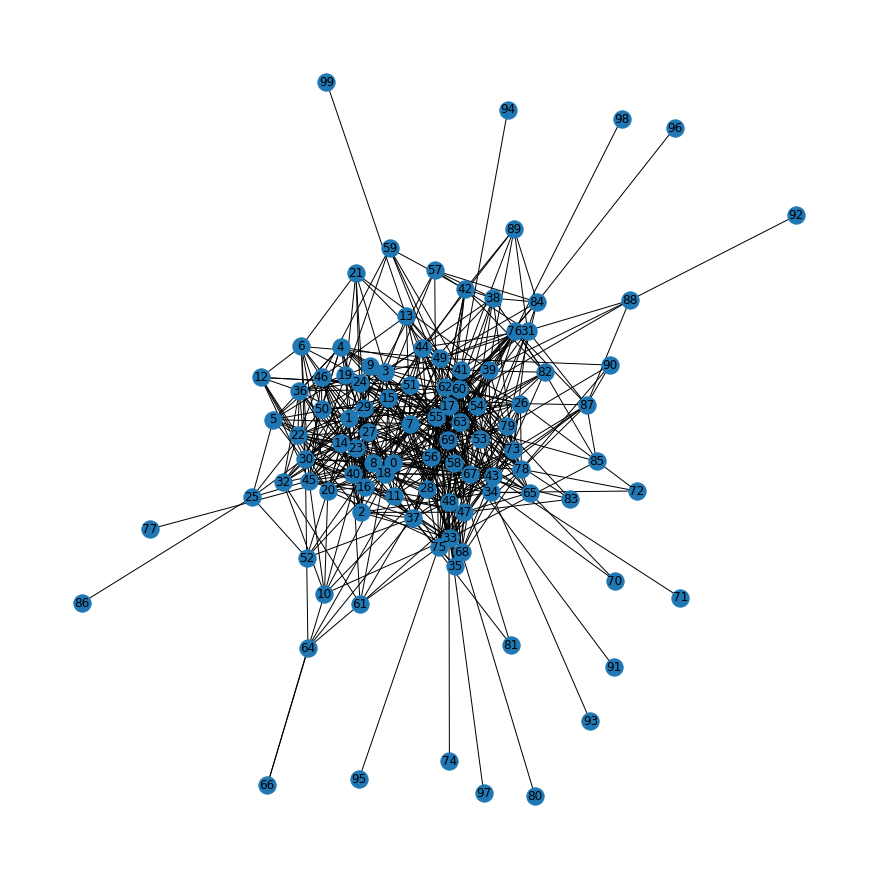

In [13]:
subax1 = plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=True, font_weight='light',)

In [14]:
from networkx import sigma, omega

# sigma(G, niter=100, nrand=10, seed=None)
# niter: 每条边重新布线的近似次数，以计算等价的随机图。
# nrand: 生成的用于计算平均聚类系数(CR)和平均最短路径长度(LR)的随机图的数量。
# more details from https://www.osgeo.cn/networkx/reference/algorithms/smallworld.html

print(sigma(G, niter=10, nrand=2)) # sigma(G)>1 for small world network
print(omega(G, niter=10, nrand=2)) # omega(G)->0 for small world property

1.2371272742554824
0.6390952466978117


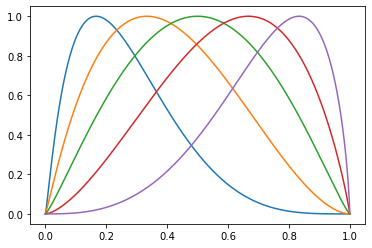

In [10]:
def TimeWindowFunction(t, i, k, alpha):
    # 改成gamma分布
    mu = i / (k+1)
    lamda = -math.log(2, mu) # -np.log2(2)/np.log2(mu), 换底公式
    return (16 * t**(2*lamda) * ((t**lamda-1)**2))**(alpha/mu)

T = np.arange(0, 1.001, 0.001)
y = []
for t in T:
    y.append([TimeWindowFunction(t, j, 5, 0.3) for j in range(1,6)])
y = np.array(y)
plt.plot(T, y[:,0])
plt.plot(T, y[:,1])
plt.plot(T, y[:,2])
plt.plot(T, y[:,3])
plt.plot(T, y[:,4])

In [5]:
config = {
    'alpha':0.5,
    'decay':0.5,
    'thr': 1.2,
    'R': 0.05,
    'p': 0.25,
    'gamma': 1.0,
}
model = config_model(config)
# print(1000**2-(model.A==0).sum())
# print(spectral_radius(model.A))
rollout(config)

0.15333333333333332 0.115


{'objs': (-0.115,)}

In [ ]:
train_loader, test_loader = MNIST_generation(train_num=100,
                                             test_num=250,
                                             batch_size=13)

inference(model, train_loader, frames=20)

t = time.time()
rollout(config)
print(time.time()-t)

1.0000000000000016


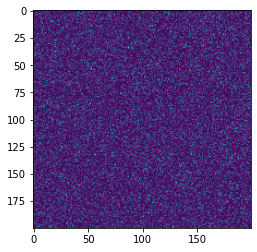

In [34]:
gamma_list = [np.random.gamma(1.0) for _ in range(40000)]
gamma_m = np.array(gamma_list).reshape(200,200)
gamma_m /= spectral_radius(gamma_m)
print(spectral_radius(gamma_m))
plt.imshow(gamma_m)
# plt.hist(gamma_list,bins=100)